Problem statement: To build a CNN based model which can accurately detect melanoma. Melanoma is a type of cancer that can be deadly if not detected early. It accounts for 75% of skin cancer deaths. A solution which can evaluate images and alert the dermatologists about the presence of melanoma has the potential to reduce a lot of manual effort needed in diagnosis.

### Importing Skin Cancer Data

### Importing all the important libraries

In [1]:
import pathlib
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
import PIL
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
import pathlib
from PIL import Image
from tensorflow.keras import layers, models
import Augmentor
from glob import glob
from tensorflow.keras import regularizers
from tensorflow.keras.callbacks import EarlyStopping

2024-09-17 17:54:30.173967: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


This assignment uses a dataset of about 2357 images of skin cancer types. The dataset contains 9 sub-directories in each train and test subdirectories. The 9 sub-directories contains the images of 9 skin cancer types respectively.

In [2]:
# Defining the path for train and test images
data_dir_train = pathlib.Path('/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train')
data_dir_test = pathlib.Path('/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Test')

In [3]:
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f"Number of training images: {image_count_train}")
image_count_test = len(list(data_dir_test.glob('*/*.jpg')))
print(f"Number of testing images: {image_count_test}")

Number of training images: 2239
Number of testing images: 118


In [4]:
# Check the shape (dimensions) of the images in the train set
print("\nTrain data image shapes:")
for image_path in data_dir_train.glob('*/*.jpg'):
    with Image.open(image_path) as img:
        print(f"Image: {image_path.name}, Size: {img.size}")  # img.size returns (width, height)

# Check the shape (dimensions) of the images in the test set
print("\nTest data image shapes:")
for image_path in data_dir_test.glob('*/*.jpg'):
    with Image.open(image_path) as img:
        print(f"Image: {image_path.name}, Size: {img.size}")


Train data image shapes:
Image: ISIC_0010550.jpg, Size: (1024, 768)
Image: ISIC_0011128.jpg, Size: (1024, 768)
Image: ISIC_0010587.jpg, Size: (1024, 768)
Image: ISIC_0010034.jpg, Size: (1024, 768)
Image: ISIC_0000555.jpg, Size: (833, 680)
Image: ISIC_0010746.jpg, Size: (1024, 768)
Image: ISIC_0001105.jpg, Size: (3072, 2304)
Image: ISIC_0010791.jpg, Size: (1024, 768)
Image: ISIC_0010785.jpg, Size: (1024, 768)
Image: ISIC_0010140.jpg, Size: (1024, 768)
Image: ISIC_0000390.jpg, Size: (3072, 2304)
Image: ISIC_0000151.jpg, Size: (2048, 1536)
Image: ISIC_0000145.jpg, Size: (2048, 1536)
Image: ISIC_0010394.jpg, Size: (1024, 768)
Image: ISIC_0010380.jpg, Size: (1024, 768)
Image: ISIC_0000144.jpg, Size: (2048, 1536)
Image: ISIC_0000150.jpg, Size: (2048, 1536)
Image: ISIC_0000420.jpg, Size: (3072, 2304)
Image: ISIC_0000434.jpg, Size: (3072, 2304)
Image: ISIC_0010784.jpg, Size: (1024, 768)
Image: ISIC_0010790.jpg, Size: (1024, 768)
Image: ISIC_0001110.jpg, Size: (3072, 2304)
Image: ISIC_0000554.

### Load using keras.preprocessing

Let's load these images off disk using the helpful image_dataset_from_directory utility.

In [5]:
# Create the original DataFrame
path_list_original = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_original = [os.path.basename(os.path.dirname(y)) for y in path_list_original]
original_df = pd.DataFrame(list(zip(path_list_original, lesion_list_original)), columns=['Path', 'Label'])


### Create a dataset

Define some parameters for the loader:

In [6]:
batch_size = 32
img_height = 180
img_width = 180
seed = 123

Use 80% of the images for training, and 20% for validation.

In [7]:
# Create the training dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 2239 files belonging to 9 classes.


In [8]:
# Create the validation (test) dataset
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_test,
    seed=seed,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 118 files belonging to 9 classes.


In [9]:
# Class names of all the classes of skin cancer and store them in a list. 
class_names = train_ds.class_names
print(class_names)

['actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 'squamous cell carcinoma', 'vascular lesion']


### Visualize the data

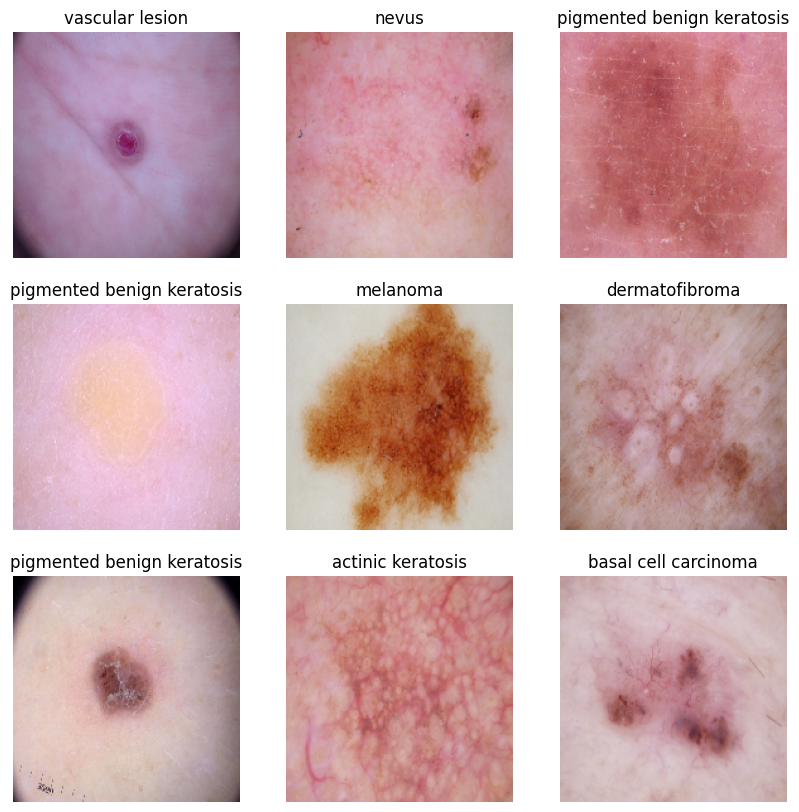

In [10]:
# Get one batch of training data
image_batch, label_batch = next(iter(train_ds))

# Create a mapping from labels to class names
label_to_class = {i: class_name for i, class_name in enumerate(class_names)}

# Visualize a few images along with their labels
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    img = image_batch[i].numpy().astype("uint8")
    label = label_batch[i].numpy()
    plt.imshow(img)
    plt.title(label_to_class[label])
    plt.axis("off")
plt.show()

In [11]:
# Check the shape of one batch of images and labels
for image_batch, label_batch in train_ds.take(1):
    print("Image batch shape:", image_batch.shape)
    print("Label batch shape:", label_batch.shape)


Image batch shape: (32, 180, 180, 3)
Label batch shape: (32,)


2024-09-17 17:54:58.006593: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


The `image_batch` is a tensor of the shape `(32, 180, 180, 3)`. This is a batch of 32 images of shape `180x180x3` (the last dimension refers to color channels RGB). The `label_batch` is a tensor of the shape `(32,)`, these are corresponding labels to the 32 images.

`Dataset.cache()` keeps the images in memory after they're loaded off disk during the first epoch.

`Dataset.prefetch()` overlaps data preprocessing and model execution while training.

In [12]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

### Create the model
#### Todo: Create a CNN model, which can accurately detect 9 classes present in the dataset. Use ```layers.experimental.preprocessing.Rescaling``` to normalize pixel values between (0,1). The RGB channel values are in the `[0, 255]` range. This is not ideal for a neural network. Here, it is good to standardize values to be in the `[0, 1]`

In [13]:
# Number of classes
num_classes = len(class_names)

# Create the model
model = models.Sequential([
    
    # Normalize the pixel values to [0,1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Third convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the output from convolutional layers
    layers.Flatten(),
    
    # Fully connected layer
    layers.Dense(128, activation='relu'),
    
    # Output layer (number of classes)
    layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])


/opt/anaconda3/envs/AIML/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


### Compile the model
Choose an appropirate optimiser and loss function for model training 

In [14]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [15]:
# View the summary of all layers
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Train the model

In [16]:
epochs = 20
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/20


2024-09-17 17:55:16.425199: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 33 of 1000
2024-09-17 17:55:26.474873: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:450] ShuffleDatasetV3:18: Filling up shuffle buffer (this may take a while): 61 of 1000
2024-09-17 17:55:29.252513: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:480] Shuffle buffer filled.


70/70 ━━━━━━━━━━━━━━━━━━━━ 169s 2s/step - accuracy: 0.2400 - loss: 2.3013 - val_accuracy: 0.2119 - val_loss: 2.0677
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 141s 2s/step - accuracy: 0.4266 - loss: 1.6112 - val_accuracy: 0.3305 - val_loss: 2.3264
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 170s 2s/step - accuracy: 0.5116 - loss: 1.4474 - val_accuracy: 0.3475 - val_loss: 2.1580
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 200s 3s/step - accuracy: 0.5033 - loss: 1.4056 - val_accuracy: 0.3814 - val_loss: 2.2204
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.5640 - loss: 1.2496 - val_accuracy: 0.3390 - val_loss: 2.0141
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 194s 3s/step - accuracy: 0.5576 - loss: 1.2799 - val_accuracy: 0.3220 - val_loss: 2.4042
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 221s 3s/step - accuracy: 0.5618 - loss: 1.2478 - val_accuracy: 0.3305 - val_loss: 2.2101
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 187s 3s/step - accuracy: 0.6047 - loss: 1.1188 - val_accuracy: 0.3559 - val_loss: 2.

### Visualizing training results

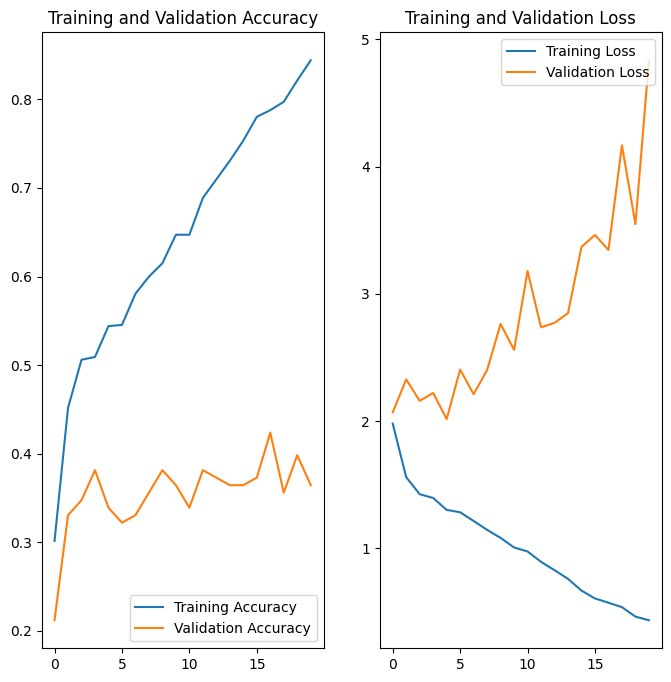

In [17]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

### Write your findings here

Based on the training results shown in the graph, it appears that model might be overfitting, as the training accuracy improves steadily while the validation accuracy fluctuates and the validation loss increases over time. A good way to address this is by applying data augmentation to introduce more variability in the training images and prevent the model from memorizing the dataset.

In [18]:
# Data augmentation strategy
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Build the model with data augmentation
model = models.Sequential([
    
    # Normalize the pixel values to [0,1] and define input shape
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    # Add data augmentation layer after defining the input shape
    data_augmentation,
    
    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Third convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    
    # Flatten the output from convolutional layers
    layers.Flatten(),
    
    # Fully connected layer
    layers.Dense(128, activation='relu'),
    
    # Output layer (number of classes)
    layers.Dense(num_classes, activation='softmax')  # Softmax for multi-class classification
])

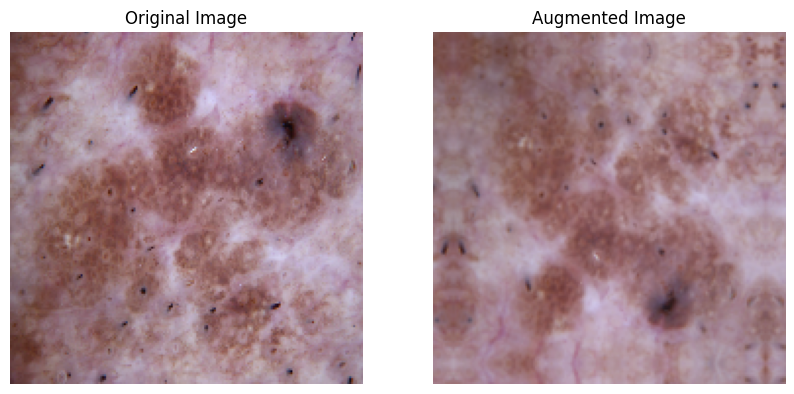

In [19]:
# Retrieve a single batch from the training dataset
image_batch, label_batch = next(iter(train_ds))

# Choose a single image from the batch
sample_image = image_batch[0]

# Create a figure to show original and augmented images
plt.figure(figsize=(10, 10))

# Original image
plt.subplot(1, 2, 1)
plt.imshow(sample_image.numpy().astype("uint8"))
plt.title("Original Image")
plt.axis("off")

# Augmented image
augmented_image = data_augmentation(tf.expand_dims(sample_image, 0))

plt.subplot(1, 2, 2)
plt.imshow(tf.squeeze(augmented_image).numpy().astype("uint8"))
plt.title("Augmented Image")
plt.axis("off")

plt.show()

### Create the model, compile and train the model


In [20]:
# Data augmentation strategy
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Build the model with data augmentation
model = models.Sequential([
    
    # Normalize the pixel values to [0,1] and define input shape
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
    
    # Add data augmentation layer after defining the input shape
    data_augmentation,
    
    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),
    
    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),
    
    # Third convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu'),
    layers.MaxPooling2D(pool_size=(2, 2)),
    layers.Dropout(0.4),
    
    # Flatten the output from convolutional layers
    layers.Flatten(),
    
    # Fully connected layer
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.4),
    
    # Output layer (number of classes)
    layers.Dense(num_classes, activation='softmax')  
])

### Compiling the model

In [21]:
# Compile the model
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# Summary of the model architecture
model.summary()

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_3 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 51200)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │     6,553,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 9)              │         1,161 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,648,137 (25.36 MB)

 Trainable params: 6,648,137 (25.36 MB)

 Non-trainable params: 0 (0.00 B)

### Training the model

In [22]:
# Train the model with augmented data and dropout
epochs = 20 

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 266s 4s/step - accuracy: 0.1985 - loss: 3.4209 - val_accuracy: 0.1356 - val_loss: 2.1737
Epoch 2/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 222s 3s/step - accuracy: 0.2115 - loss: 2.0436 - val_accuracy: 0.1610 - val_loss: 2.2003
Epoch 3/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 220s 3s/step - accuracy: 0.2505 - loss: 1.9615 - val_accuracy: 0.2458 - val_loss: 2.1797
Epoch 4/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.3151 - loss: 1.8434 - val_accuracy: 0.2966 - val_loss: 2.2255
Epoch 5/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 262s 4s/step - accuracy: 0.3576 - loss: 1.7384 - val_accuracy: 0.3220 - val_loss: 2.0792
Epoch 6/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 223s 3s/step - accuracy: 0.3999 - loss: 1.6994 - val_accuracy: 0.3136 - val_loss: 2.0923
Epoch 7/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 217s 3s/step - accuracy: 0.4045 - loss: 1.6627 - val_accuracy: 0.3220 - val_loss: 2.0153
Epoch 8/20
70/70 ━━━━━━━━━━━━━━━━━━━━ 216s 3s/step - accuracy: 0.4727 - loss: 1.5526 - val_accuracy: 0.3136 - v

### Visualizing the results

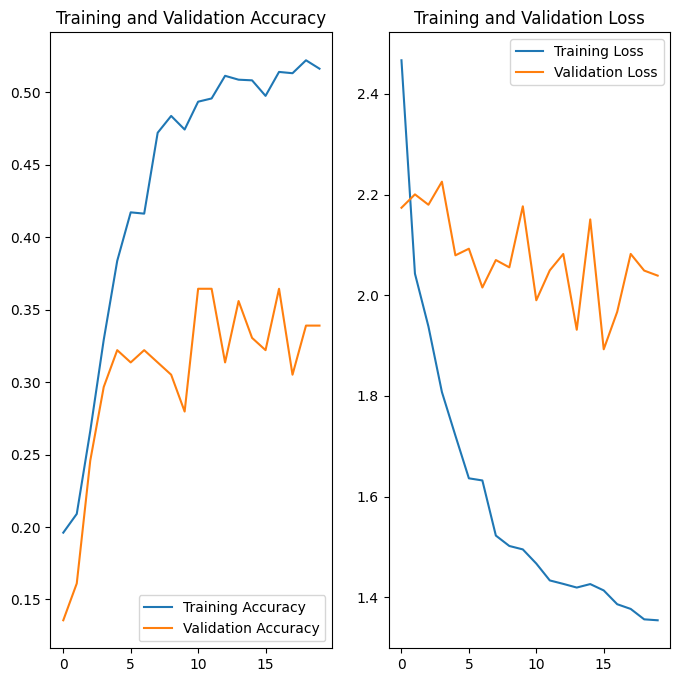

In [23]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### Todo: Write your findings after the model fit, see if there is an evidence of model overfit or underfit. Do you think there is some improvement now as compared to the previous model run?

The training accuracy is increasing and approaches ~0.5 by the end of the 20 epochs, indicating the model is learning from the training data but the validation accuracy fluctuates and does not show consistent improvement, hovering around ~0.35–0.4, and even decreases towards the end of training.

Training and Validation Loss:
The training loss steadily decreases, which means that the model is minimizing the error for the training set.
The validation loss, however, fluctuates significantly and does not decrease in the same way. This indicates that the model may be struggling to generalize on the validation set.

Evidence of Overfitting:
Overfitting Evidence: Despite the increasing training accuracy, the validation accuracy does not improve correspondingly, and the validation loss fluctuates. This gap between training and validation performance suggests that the model is overfitting to the training data.
Improvement from Previous Model Run: While the training accuracy has improved compared to the previous run (based on assumption), the issue of overfitting remains present. 

#### **Todo:** Find the distribution of classes in the training dataset.
#### **Context:** Many times real life datasets can have class imbalance, one class can have proportionately higher number of samples compared to the others. Class imbalance can have a detrimental effect on the final model quality. Hence as a sanity check it becomes important to check what is the distribution of classes in the data.

In [24]:
# Define the class names
class_names = [
    'actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 
    'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 
    'squamous cell carcinoma', 'vascular lesion'
]

# Initialize a dictionary to count occurrences of each label
class_counts = {i: 0 for i in range(len(class_names))}

# Iterate through the training dataset
for images, labels in train_ds:
    # Convert labels to numpy array if necessary
    labels = labels.numpy() if isinstance(labels, tf.Tensor) else labels
    for label in labels:
        # Convert TensorFlow tensors to native Python int
        label = int(label)
        class_counts[label] += 1

# Print the class distribution with names
for label, count in class_counts.items():
    print(f"Class '{class_names[label]}': {count} samples")


Class 'actinic keratosis': 114 samples
Class 'basal cell carcinoma': 376 samples
Class 'dermatofibroma': 95 samples
Class 'melanoma': 438 samples
Class 'nevus': 357 samples
Class 'pigmented benign keratosis': 462 samples
Class 'seborrheic keratosis': 77 samples
Class 'squamous cell carcinoma': 181 samples
Class 'vascular lesion': 139 samples


2024-09-17 20:04:27.134113: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


#### - Which class has the least number of samples?
Seborrheic keratosis has least number of samples. 
#### - Which classes dominate the data in terms proportionate number of samples?
Pigmented benign keratosis has the highest number of samples.

#### **Todo:** Rectify the class imbalance
#### **Context:** You can use a python package known as `Augmentor` (https://augmentor.readthedocs.io/en/master/) to add more samples across all classes so that none of the classes have very few samples.

To use `Augmentor`, the following general procedure is followed:

1. Instantiate a `Pipeline` object pointing to a directory containing your initial image data set.<br>
2. Define a number of operations to perform on this data set using your `Pipeline` object.<br>
3. Execute these operations by calling the `Pipeline’s` `sample()` method.


### Determine the Maximum Number of Samples

In [25]:
# Directory containing the training dataset
data_dir_train = '/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train'

# Get the class names
class_names = [
    'actinic keratosis', 'basal cell carcinoma', 'dermatofibroma', 'melanoma', 
    'nevus', 'pigmented benign keratosis', 'seborrheic keratosis', 
    'squamous cell carcinoma', 'vascular lesion'
]

# Dictionary to store the number of samples per class
class_counts = {}

# Find the class with the maximum number of samples
max_samples = 0
for class_name in class_names:
    class_dir = os.path.join(data_dir_train, class_name)
    # Only count .jpg files (or modify as needed)
    num_samples = len([file for file in os.listdir(class_dir) if file.endswith('.jpg')])
    class_counts[class_name] = num_samples
    if num_samples > max_samples:
        max_samples = num_samples

# Print class counts
for class_name, count in class_counts.items():
    print(f"Class '{class_name}': {count} samples")

print("\nMaximum number of samples in a class:", max_samples)

Class 'actinic keratosis': 114 samples
Class 'basal cell carcinoma': 376 samples
Class 'dermatofibroma': 95 samples
Class 'melanoma': 438 samples
Class 'nevus': 357 samples
Class 'pigmented benign keratosis': 462 samples
Class 'seborrheic keratosis': 77 samples
Class 'squamous cell carcinoma': 181 samples
Class 'vascular lesion': 139 samples

Maximum number of samples in a class: 462


### Augmenting Underrepresented Classes

In [26]:
# Path to the training dataset
data_dir_train = '/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train'

# Class names and their sample counts
class_counts = {
    'actinic keratosis': 114,
    'basal cell carcinoma': 376,
    'dermatofibroma': 95,
    'melanoma': 438,
    'nevus': 357,
    'pigmented benign keratosis': 462,  # Maximum class
    'seborrheic keratosis': 77,
    'squamous cell carcinoma': 181,
    'vascular lesion': 139
}

max_samples = 462  # Set the max_samples to match the largest class

# Loop through each class and augment if necessary
for class_name, num_samples in class_counts.items():
    class_dir = os.path.join(data_dir_train, class_name)
    
    if num_samples < max_samples:
        p = Augmentor.Pipeline(source_directory=class_dir, output_directory=class_dir)
        
        # Add desired augmentation operations
        p.flip_left_right(probability=0.5)
        p.flip_top_bottom(probability=0.5)
        p.rotate(probability=0.5, max_left_rotation=10, max_right_rotation=10)
        p.zoom_random(probability=0.5, percentage_area=0.8)
        p.random_brightness(probability=0.5, min_factor=0.7, max_factor=1.3)
        p.random_contrast(probability=0.5, min_factor=0.7, max_factor=1.3)
        p.skew(probability=0.5)
        p.shear(probability=0.5, max_shear_left=10, max_shear_right=10)
        
        # Calculate the number of samples to generate
        samples_to_generate = max_samples - num_samples
        
        # Generate the required samples
        p.sample(samples_to_generate)
        
        print(f"Augmented '{class_name}' from {num_samples} to {max_samples} samples.")
    else:
        print(f"Class '{class_name}' already has {num_samples} samples; no augmentation needed.")


Initialised with 114 image(s) found.
Output directory set to /Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/actinic keratosis.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x133A08D70>: 100%|██████████| 348/348 [00:22<00:00, 15.60 Samples/s]


Augmented 'actinic keratosis' from 114 to 462 samples.
Initialised with 376 image(s) found.
Output directory set to /Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/basal cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x133B15AF0>: 100%|██████████| 86/86 [00:04<00:00, 18.30 Samples/s]


Augmented 'basal cell carcinoma' from 376 to 462 samples.
Initialised with 95 image(s) found.
Output directory set to /Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/dermatofibroma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x1339C40E0>: 100%|██████████| 367/367 [00:22<00:00, 16.56 Samples/s]                  


Augmented 'dermatofibroma' from 95 to 462 samples.
Initialised with 438 image(s) found.
Output directory set to /Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/melanoma.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x13392E6C0>: 100%|██████████| 24/24 [00:07<00:00,  3.32 Samples/s] 


Augmented 'melanoma' from 438 to 462 samples.
Initialised with 357 image(s) found.
Output directory set to /Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/nevus.

Processing <PIL.Image.Image image mode=RGB size=767x576 at 0x133901190>: 100%|██████████| 105/105 [00:29<00:00,  3.53 Samples/s]  


Augmented 'nevus' from 357 to 462 samples.
Class 'pigmented benign keratosis' already has 462 samples; no augmentation needed.
Initialised with 77 image(s) found.
Output directory set to /Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/seborrheic keratosis.

Processing <PIL.Image.Image image mode=RGB size=1024x768 at 0x133AC0800>: 100%|██████████| 385/385 [01:01<00:00,  6.25 Samples/s]                  


Augmented 'seborrheic keratosis' from 77 to 462 samples.
Initialised with 181 image(s) found.
Output directory set to /Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/squamous cell carcinoma.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x133AC0EC0>: 100%|██████████| 281/281 [00:17<00:00, 16.07 Samples/s]                  


Augmented 'squamous cell carcinoma' from 181 to 462 samples.
Initialised with 139 image(s) found.
Output directory set to /Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/vascular lesion.

Processing <PIL.Image.Image image mode=RGB size=600x450 at 0x13391E240>: 100%|██████████| 323/323 [00:20<00:00, 15.40 Samples/s]

Augmented 'vascular lesion' from 139 to 462 samples.


Augmentor has stored the augmented images in the output sub-directory of each of the sub-directories of skin cancer types.. Lets take a look at total count of augmented images.

### Verify Augmentation

In [27]:
# Recalculate class counts
for class_name in class_names:
    class_dir = os.path.join(data_dir_train, class_name)
    num_samples = len(os.listdir(class_dir))
    print(f"Class '{class_name}' now has {num_samples} samples.")

Class 'actinic keratosis' now has 462 samples.
Class 'basal cell carcinoma' now has 462 samples.
Class 'dermatofibroma' now has 462 samples.
Class 'melanoma' now has 462 samples.
Class 'nevus' now has 462 samples.
Class 'pigmented benign keratosis' now has 462 samples.
Class 'seborrheic keratosis' now has 462 samples.
Class 'squamous cell carcinoma' now has 462 samples.
Class 'vascular lesion' now has 462 samples.


### Create DataFrame of Augmented Images

In [31]:
# Convert the data_dir_train string to a Path object
data_dir_train = pathlib.Path('/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train')

# Count the images in the main class directories
image_count_train = len(list(data_dir_train.glob('*/*.jpg')))
print(f'Total training images: {image_count_train}')


Total training images: 4158


### Lets see the distribution of augmented data after adding new images to the original training data.

In [32]:
path_list = [x for x in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
path_list

['/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/melanoma/ISIC_0010550.jpg',
 '/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/melanoma/ISIC_0011128.jpg',
 '/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/melanoma/ISIC_0010587.jpg',
 '/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/melanoma/ISIC_0010034.jpg',
 '/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/melanoma/ISIC_0000555.jpg',
 '/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/melanoma/ISIC_0010746.jpg',
 '/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/melanoma/ISIC_0001105.jpg',
 '/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/melanoma/ISIC_0010791.jpg',
 '/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/melanoma/ISIC_0010785.jpg',
 '/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train/melanoma/ISIC_0010140.jpg',
 '/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/

In [33]:
lesion_list_new = [os.path.basename(os.path.dirname(y)) for y in glob(os.path.join(data_dir_train, '*', '*.jpg'))]
lesion_list_new


['melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',
 'melanoma',

In [34]:
dataframe_dict_new = dict(zip(path_list, lesion_list_new))

### Concatenate the Augmented DataFrame with the Original DataFrame

In [35]:
df2 = pd.DataFrame(list(dataframe_dict_new.items()),columns = ['Path','Label'])
#new_df = original_df.append(df2)

# Concatenate original_df and df2
new_df = pd.concat([original_df, df2], ignore_index=True)


In [36]:
new_df['Label'].value_counts()

Label
pigmented benign keratosis    924
melanoma                      900
basal cell carcinoma          838
nevus                         819
squamous cell carcinoma       643
vascular lesion               601
actinic keratosis             576
dermatofibroma                557
seborrheic keratosis          539
Name: count, dtype: int64

So, now we have added 500 images to all the classes to maintain some class balance. We can add more images as we want to improve training process.

#### **Todo**: Train the model on the data created using Augmentor

In [ ]:
batch_size = 32
img_height = 180
img_width = 180

#### **Todo:** Create a training dataset

In [37]:
#data_dir_train="path to directory with training data + data created using augmentor"
data_dir_train = pathlib.Path('/Users/rushi/Upgrad-assignments/Melanoma/Skin cancer ISIC/Train')

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = 'training', ## Todo choose the correct parameter value, so that only training data is refered to,,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4158 files belonging to 9 classes.
Using 3327 files for training.


#### **Todo:** Create a validation dataset

In [38]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir_train,
    seed=123,
    validation_split = 0.2,
    subset = 'validation', ## Todo choose the correct parameter value, so that only validation data is refered to,
    image_size=(img_height, img_width),
    batch_size=batch_size)

Found 4158 files belonging to 9 classes.
Using 831 files for validation.


#### **Todo:** Create your model (make sure to include normalization)

In [39]:
# Define the EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

# Data augmentation strategy
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomContrast(0.2),
])

# Define the model
model = models.Sequential([

    # Normalize the pixel values to [0,1]
    layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),

    # Add data augmentation layer after defining the input shape
    data_augmentation,

    # First convolutional layer
    layers.Conv2D(32, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Second convolutional layer
    layers.Conv2D(64, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Third convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Fourth convolutional layer
    layers.Conv2D(128, (3, 3), activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.MaxPooling2D((2, 2)),
    layers.Dropout(0.3),

    # Flatten the output from convolutional layers
    layers.Flatten(),

    # Fully connected layer
    layers.Dense(512, activation='relu',kernel_regularizer=regularizers.l2(0.001)),
    layers.Dropout(0.3),

    # Output layer (number of classes)
    layers.Dense(len(train_ds.class_names), activation='softmax')  # Softmax for multi-class classification
])


/opt/anaconda3/envs/AIML/lib/python3.12/site-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [40]:
#Compiling the model
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)
# Summary of the model architecture
model.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_3 (Rescaling)         │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_5 (Sequential)       │ (None, 180, 180, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_9 (Conv2D)               │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_9 (MaxPooling2D)  │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_10 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_11 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_12 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_3 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │     5,308,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_8 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 9)              │         4,617 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,554,377 (21.19 MB)

 Trainable params: 5,554,377 (21.19 MB)

 Non-trainable params: 0 (0.00 B)

In [41]:
# Train the model
epochs = 30  

history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=epochs
)

Epoch 1/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 366s 3s/step - accuracy: 0.1355 - loss: 3.0218 - val_accuracy: 0.2696 - val_loss: 2.0843
Epoch 2/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 269s 3s/step - accuracy: 0.2734 - loss: 2.0021 - val_accuracy: 0.2539 - val_loss: 2.0013
Epoch 3/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 271s 3s/step - accuracy: 0.2992 - loss: 1.8248 - val_accuracy: 0.3345 - val_loss: 1.8136
Epoch 4/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 357s 3s/step - accuracy: 0.3339 - loss: 1.7852 - val_accuracy: 0.3490 - val_loss: 1.7652
Epoch 5/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 370s 3s/step - accuracy: 0.3544 - loss: 1.7422 - val_accuracy: 0.3394 - val_loss: 1.7735
Epoch 6/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 319s 3s/step - accuracy: 0.3566 - loss: 1.6648 - val_accuracy: 0.3321 - val_loss: 1.7051
Epoch 7/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 258s 2s/step - accuracy: 0.3571 - loss: 1.7075 - val_accuracy: 0.3779 - val_loss: 1.6875
Epoch 8/30
104/104 ━━━━━━━━━━━━━━━━━━━━ 259s 2s/step - accuracy: 0.3460 - loss: 1.6706 - val_accu

#### **Todo:**  Visualize the model results

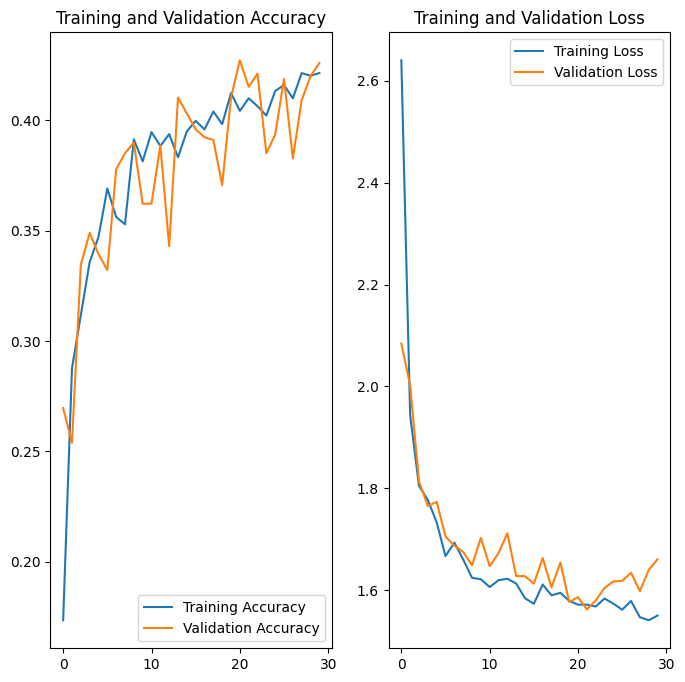

In [42]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### **Todo:**  Analyze your results here. Did you get rid of underfitting/overfitting? Did class rebalance help?

